# National Household Survey 
# Trip rates analysis and comparison with NCHRP716

In [1]:
from dbfread import DBF
import pandas as pd
import numpy as np
from pandas import ExcelWriter
import plotly.express as px
import matplotlib.pyplot as plt
import contextily as ctx
import plotly.subplots as sp
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

In [2]:
# Read the CSV file with specified encoding and store it in a DataFrame called 'csv_data'.
# Encoding is set to 'ISO-8859-1' to handle special characters.
csv_data = pd.read_csv('2022/VDOT share/AddonTRIP_VDOT_V2.csv', encoding='ISO-8859-1')

# Extract the specified columns from 'csv_data' and store them back in 'csv_data'.
# Also, remove any duplicate rows.
csv_data = csv_data[['HOUSEID', 'ORIGIN_LOCNAME', 'DESTINATION_LOCNAME', 'STRTTIME', 'ENDTIME', 
                     'TRPMILES', 'WTTRDFIN_VA', 'WTTRDFIN5D_VA', 'WTTRDFIN2D_VA', 'DRVR_FLG', 'TRPTRANS']].drop_duplicates()


## Filter the Household coordinates within the model area

In [3]:

# Read the CSV file with the specified encoding and load it into a DataFrame called 'csv_data_HH'.
csv_data_HH = pd.read_csv('2022/VDOT share/AddonHH_VDOT_V2.csv', encoding='ISO-8859-1')

# List the available columns in 'csv_data_HH' (This line is more for your reference and doesn't affect subsequent code)
csv_data_HH.columns

# Keep only the columns of interest and remove duplicate rows, storing the result back in 'csv_data_HH'.
csv_data_HH = csv_data_HH[['HOUSEID', 'WTHHFIN5D_VA', 'HHSIZE', 'HHVEHCNT', 'CONFIRMEDHOME_LONGITUDE', 'CONFIRMEDHOME_LATITUDE']].drop_duplicates()

# Load the shapefile into a GeoDataFrame called 'shapefile'.
shapefile = gpd.read_file('2022/PDC_geo_split/SE_data_models/RTC_2017/rtc_convert.shp')

# Create a new column 'HH_location' which contains Point objects representing the longitude and latitude of each household.
csv_data_HH['HH_location'] = csv_data_HH.apply(lambda row: Point(row.CONFIRMEDHOME_LONGITUDE, row.CONFIRMEDHOME_LATITUDE), axis=1)

# Convert the pandas DataFrame 'csv_data_HH' to a GeoDataFrame 'gdf', setting 'HH_location' as the geometry.
gdf = gpd.GeoDataFrame(csv_data_HH, geometry='HH_location')

# Check if each household point in 'gdf' is within the shapefile's area.
HH_within = gdf.within(shapefile.unary_union)

# Filter 'csv_data_HH' to keep only the rows where the household is within the shapefile's area.
csv_data_HH_MPO = csv_data_HH[HH_within]

# 'csv_data_HH_MPO' will contain households whose locations are within the shapefile's area.

## Filter Trip origin coordinates within the model area

In [4]:

# Load the shapefile
shapefile = gpd.read_file('2022/PDC_geo_split/SE_data_models/RTC_2017/rtc_convert.shp')

# Load the csv file
csv_file = pd.read_csv('2022/VDOT share/AddonTRIP_VDOT_V2.csv', encoding='ISO-8859-1')


# Convert the latitude and longitude to geometric points
csv_file['ORIGIN'] = csv_file.apply(lambda row: Point(row.ORIGIN_LON, row.ORIGIN_LAT), axis=1)
csv_file['DESTINATION'] = csv_file.apply(lambda row: Point(row.DESTINATION_LON, row.DESTINATION_LAT), axis=1)

# Convert the pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(csv_file, geometry='ORIGIN')

# Check if the origin points are within the shapefile
origin_within = gdf.within(shapefile.unary_union)
df_selected = csv_file[origin_within]


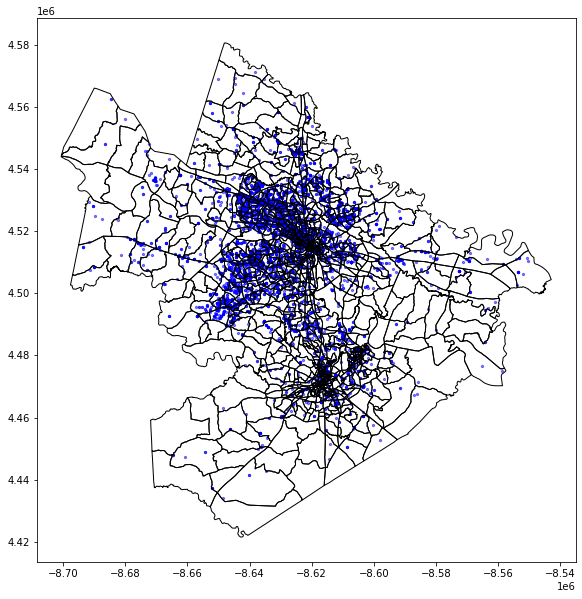

In [5]:
# Convert the pandas DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df_selected, geometry=gpd.points_from_xy(df_selected.ORIGIN_LON, df_selected.ORIGIN_LAT))

# Set the coordinate system to Web Mercator
gdf = gdf.set_crs("EPSG:4326").to_crs("EPSG:3857")

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', alpha=0.5, markersize=5)
shapefile.to_crs("EPSG:3857").boundary.plot(ax=ax, color='black', linewidth=1)

# Add a basemap
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

## ## Join the HH_MPO and trip location data with HOUSEID field


In [6]:

df_selected.drop(columns=['HHSIZE'], inplace=True)
df_selected_1 = pd.merge(df_selected, csv_data_HH_MPO, how='inner', left_on='HOUSEID', right_on='HOUSEID')
df_selected=df_selected_1.copy()

C:\windows\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
df_combined = df_selected[['HOUSEID','PERSONID','TRIPID','HHSIZE','HHVEHCNT', 'WTHHFIN5D_VA','ORIGIN_LOCNAME', 'DESTINATION_LOCNAME','STRTTIME','ENDTIME', 'TRPMILES',
                     'WTTRDFIN_VA','WTTRDFIN5D_VA','WTTRDFIN2D_VA','DRVR_FLG','TRPTRANS']].drop_duplicates()
df_combined

,HOUSEID,PERSONID,TRIPID,HHSIZE,HHVEHCNT,WTHHFIN5D_VA,ORIGIN_LOCNAME,DESTINATION_LOCNAME,STRTTIME,ENDTIME,TRPMILES,WTTRDFIN_VA,WTTRDFIN5D_VA,WTTRDFIN2D_VA,DRVR_FLG,TRPTRANS
0,8000020345,1,1,2,2,0.000000,HOME,OTHER,900,930,12.218148,31547.52710,0.00000,53140.33291,1,1
1,8000020345,1,2,2,2,0.000000,OTHER,HOME,1200,1230,16.032318,31547.52710,0.00000,53140.33291,1,1
2,8000020345,2,1,2,2,0.000000,HOME,OTHER,900,930,12.218148,20613.57899,0.00000,28018.75345,2,1
3,8000020345,2,2,2,2,0.000000,OTHER,HOME,1200,1230,16.032318,20613.57899,0.00000,28018.75345,2,1
4,8000020348,1,1,1,1,132.838110,HOME,OTHER,1415,1425,3.795525,33007.66110,24918.05290,0.00000,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6672,9000211510,1,4,2,2,128.946912,OTHER,OTHER,1015,1025,4.420758,18556.29804,18666.97982,0.00000,1,4
6673,9000211510,1,5,2,2,128.946912,OTHER,HOME,1125,1135,3.174643,18556.29804,18666.97982,0.00000,1,4
6674,9000211510,2,1,2,2,128.946912,HOME,WORK,750,755,0.869484,34248.93308,34116.23756,0.00000,1,3
6675,9000211510,2,2,2,2,128.946912,WORK,OTHER,1635,1645,1.643257,34248.93308,34116.23756,0.00000,1,3


## Calculate the Trip rates based on the definition and formula from NHTS

In [8]:
# Import the required datetime module
from datetime import time

# Convert 'STRTTIME' and 'ENDTIME' to time format
# It pads zeros to make sure time is in HHMM format and then converts it to Python's time object.
df_combined['time1'] = pd.to_datetime(df_combined['STRTTIME'].astype(str).str.zfill(4), format='%H%M').dt.time
df_combined['time2'] = pd.to_datetime(df_combined['ENDTIME'].astype(str).str.zfill(4), format='%H%M').dt.time

# Calculate the trip time in minutes
# It subtracts the start time from the end time and converts the result to minutes.
df_combined['Trip_Time'] = (pd.to_datetime(df_combined['time2'].astype(str)) - pd.to_datetime(df_combined['time1'].astype(str))).dt.total_seconds() / 60

# Weight the trip time and trip miles by 'WTTRDFIN5D_VA'
# It multiplies the trip time and trip miles by a weighting factor.
df_combined['weighted_time'] = df_combined['Trip_Time'] * df_combined['WTTRDFIN5D_VA']
df_combined['weighted_miles'] = df_combined['TRPMILES'] * df_combined['WTTRDFIN5D_VA']

# Define time ranges for morning and evening
morning_start = time(6, 30)  # 6:30 AM
morning_end = time(8, 30)  # 8:30 AM
evening_start = time(16, 30)  # 4:30 PM
evening_end = time(18, 30)  # 6:30 PM

# Filter the DataFrame based on several conditions
# The conditions include trip miles greater than 0 and trip time greater or equal to 0.
# Additional conditions are commented out but can be included as needed.
df_calc_selected = df_combined[
#                             (df_combined['TRPTRANS'] <= 7) & 
#                             (df_combined['TRPTRANS'] >= 0) & 
#                             (df_combined['DRVR_FLG'] == 1) & 
                              (df_combined['TRPMILES'] > 0) &                      
                              (df_combined['Trip_Time'] >= 0)
#                             (df_combined['TRPMILES']/df_combined['Trip_Time'] * 60 >= 10) &
#                             (df_combined['TRPMILES']/df_combined['Trip_Time'] * 60 <= 70)
                            ]


In [9]:
df_calc_selected.DESTINATION_LOCNAME.unique()

array(['OTHER', 'HOME', 'WORK', 'SCHOOL'], dtype=object)

In [10]:
## Trip purpose categorize
def categorize_trips(row):
    if ((row['ORIGIN_LOCNAME'] == 'HOME' and row['DESTINATION_LOCNAME'] == 'WORK') or 
        (row['ORIGIN_LOCNAME'] == 'WORK' and row['DESTINATION_LOCNAME'] == 'HOME')):
        return 'HBW'
    elif ((row['ORIGIN_LOCNAME'] == 'HOME' and row['DESTINATION_LOCNAME'] != 'WORK') or 
          (row['ORIGIN_LOCNAME'] != 'WORK' and row['DESTINATION_LOCNAME'] == 'HOME')):
        return 'HBO'
    else:
        return 'NHB'

df_calc_selected['Trip_Purpose'] = df_calc_selected.apply(categorize_trips, axis=1)


C:\Users\enhua.liu\AppData\Local\Temp/ipykernel_22564/3898515268.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
df_calc_selected.head()

,HOUSEID,PERSONID,TRIPID,HHSIZE,HHVEHCNT,WTHHFIN5D_VA,ORIGIN_LOCNAME,DESTINATION_LOCNAME,STRTTIME,ENDTIME,...,WTTRDFIN5D_VA,WTTRDFIN2D_VA,DRVR_FLG,TRPTRANS,time1,time2,Trip_Time,weighted_time,weighted_miles,Trip_Purpose
0,8000020345,1,1,2,2,0.00000,HOME,OTHER,900,930,...,0.0000,53140.33291,1,1,09:00:00,09:30:00,30.0,0.000,0.000000,HBO
1,8000020345,1,2,2,2,0.00000,OTHER,HOME,1200,1230,...,0.0000,53140.33291,1,1,12:00:00,12:30:00,30.0,0.000,0.000000,HBO
2,8000020345,2,1,2,2,0.00000,HOME,OTHER,900,930,...,0.0000,28018.75345,2,1,09:00:00,09:30:00,30.0,0.000,0.000000,HBO
3,8000020345,2,2,2,2,0.00000,OTHER,HOME,1200,1230,...,0.0000,28018.75345,2,1,12:00:00,12:30:00,30.0,0.000,0.000000,HBO
4,8000020348,1,1,1,1,132.83811,HOME,OTHER,1415,1425,...,24918.0529,0.00000,1,3,14:15:00,14:25:00,10.0,249180.529,94577.096994,HBO


In [12]:
# categorize the dataset based on HHSIZE and HHVECHCNT value
# Replace values greater than 4 in the 'HHSIZE' column with 4
df_calc_selected['HHSIZE'] = df_calc_selected['HHSIZE'].apply(lambda x: x if x <= 5 else 5)

# Replace values greater than 3 in the 'HHVEHCNT' column with 3
df_calc_selected['HHVEHCNT'] = df_calc_selected['HHVEHCNT'].apply(lambda x: x if x <= 3 else 3)


C:\Users\enhua.liu\AppData\Local\Temp/ipykernel_22564/4062850250.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\enhua.liu\AppData\Local\Temp/ipykernel_22564/4062850250.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
import pandas as pd

# Pre-calculate the household matrix as it doesn't depend on 'Trip_Purpose'
df_HH_mat = (
    df_calc_selected[['HOUSEID', 'HHSIZE', 'HHVEHCNT','WTHHFIN5D_VA']]
    .drop_duplicates()
    .groupby(['HHSIZE', 'HHVEHCNT'])['WTHHFIN5D_VA']
    .sum()
    .reset_index()
    .rename(columns={'WTHHFIN5D_VA': 'HH_weight'})
)

# Initialize the results list
result_tables = []

# Loop over each unique purpose
for purpose in df_calc_selected['Trip_Purpose'].unique():
    # Filter data by purpose
    df_filtered = df_calc_selected[df_calc_selected['Trip_Purpose'] == purpose]

    # Aggregate value
    result_df = (
        df_filtered.groupby(['HHSIZE', 'HHVEHCNT'])['WTTRDFIN5D_VA']
        .sum()
        .reset_index()
        .rename(columns={'WTTRDFIN5D_VA': 'Aggregated_Value'})
    )

    # Merge with pre-calculated household matrix
    df_trip_rates = pd.merge(result_df, df_HH_mat, on=['HHSIZE', 'HHVEHCNT'])
    df_trip_rates['PURPOSE'] = purpose
    
    # Calculate trip generation rates
    df_trip_rates['trip_gen_rates'] = df_trip_rates['Aggregated_Value'] / df_trip_rates['HH_weight'] / (365/7*5)
    
    # Append to results
    result_tables.append(df_trip_rates)

# Concatenate and pivot
final_result = pd.concat(result_tables)

pivot_result = final_result.pivot_table(
    index=['PURPOSE', 'HHVEHCNT'],
    columns='HHSIZE',
    values='trip_gen_rates',
    aggfunc='sum'
).reset_index().rename_axis(None, axis=1)

# Optional column renaming
pivot_result.columns = [f'HHSIZE_{int(col)}' if isinstance(col, (int, float)) else col for col in pivot_result.columns]

print("Trip rates based on Trp_W/HH_W")
pivot_result.query('PURPOSE=="HBW"')


Trip rates based on Trp_W/HH_W


,PURPOSE,HHVEHCNT,HHSIZE_1,HHSIZE_2,HHSIZE_3,HHSIZE_4,HHSIZE_5
4,HBW,0,0.401838,1.185973,NaN,NaN,3.776115
5,HBW,1,0.358219,0.321348,0.651235,0.499922,0.916749
6,HBW,2,0.348700,0.758410,1.062159,1.299674,0.608727
7,HBW,3,0.693540,0.757303,1.655778,1.454607,1.581275


In [14]:
import pandas as pd

# List to store the result DataFrames for each purpose
result_tables = []

# Iterate through the unique purposes in the 'PURPOSE' column (replace with the actual column name)
for purpose in df_calc_selected['Trip_Purpose'].unique():
    # Filter the data by the current purpose
    df_filtered = df_calc_selected[df_calc_selected['Trip_Purpose'] == purpose]

    # Obtain the unique houseID and weights for trip rates calculation
    df_HH_mat_1 = df_calc_selected[['HOUSEID', 'HHSIZE', 'HHVEHCNT','WTHHFIN5D_VA']].drop_duplicates()

    df_HH_mat = (
        df_HH_mat_1.groupby(['HHVEHCNT'])
        .apply(lambda group: group['WTHHFIN5D_VA'].sum())
        .reset_index()
    )

    # Rename the aggregated column
    df_HH_mat.rename(columns={0: 'HH_weight'}, inplace=True)

    # Group by 'HHSIZE' and 'HHVEHCNT', and calculate the aggregation
    result_df = (
        df_filtered.groupby([ 'HHVEHCNT'])
        .apply(lambda group: group['WTTRDFIN5D_VA'].sum())
        .reset_index()
    )

    # Rename the aggregated column
    result_df.rename(columns={0: 'Aggregated_Value'}, inplace=True)
    df_trip_rates = pd.merge(result_df, df_HH_mat, how='inner', on=['HHVEHCNT'])

    # Add the purpose as a new column
    df_trip_rates['PURPOSE'] = purpose

    # Append the result DataFrame to the list
    result_tables.append(df_trip_rates)

# Concatenate the result tables into a single DataFrame
final_result = pd.concat(result_tables)

final_result = final_result.query('PURPOSE=="HBW"')

# Calculate the sum of numerical columns
sum_row = final_result.select_dtypes(include=[float, int]).sum()

# Convert the 'PURPOSE' column in the sum row to 'Total'
sum_row['PURPOSE'] = 'Total'

# Append the sum row to the DataFrame
final_result = final_result.append(sum_row, ignore_index=True)
final_result['trip_gen_rates'] = final_result['Aggregated_Value']/final_result['HH_weight']/(365/7*5)
print("2022 Richmond MPO trip rates Average by VEH_CNT")
final_result

2022 Richmond MPO trip rates Average by VEH_CNT


,HHVEHCNT,Aggregated_Value,HH_weight,PURPOSE,trip_gen_rates
0,0.0,2.077229e+06,9615.041956,HBW,0.828645
1,1.0,1.190246e+07,117847.995444,HBW,0.387391
2,2.0,3.610631e+07,170630.021064,HBW,0.811639
3,3.0,3.538757e+07,112178.869409,HBW,1.209971
4,6.0,8.547357e+07,410271.927873,Total,0.799089


In [15]:
import pandas as pd

# List to store the result DataFrames for each purpose
result_tables = []

# Iterate through the unique purposes in the 'PURPOSE' column (replace with the actual column name)
for purpose in df_calc_selected['Trip_Purpose'].unique():
    # Filter the data by the current purpose
    df_filtered = df_calc_selected[df_calc_selected['Trip_Purpose'] == purpose]

    # Obtain the unique houseID and weights for trip rates calculation
    df_HH_mat_1 = df_calc_selected[['HOUSEID', 'HHSIZE', 'HHVEHCNT','WTHHFIN5D_VA']].drop_duplicates()


    df_HH_mat = (
        df_HH_mat_1.groupby(['HHSIZE'])
        .apply(lambda group: group['WTHHFIN5D_VA'].sum())
        .reset_index()
    )

    # Rename the aggregated column
    df_HH_mat.rename(columns={0: 'HH_weight'}, inplace=True)


    # Group by 'HHSIZE' and 'HHVEHCNT', and calculate the aggregation
    result_df = (
        df_filtered.groupby([ 'HHSIZE'])
        .apply(lambda group: group['WTTRDFIN5D_VA'].sum())
        .reset_index()
    )

    # Rename the aggregated column
    result_df.rename(columns={0: 'Aggregated_Value'}, inplace=True)
    df_trip_rates = pd.merge(result_df, df_HH_mat, how='inner', on=['HHSIZE'])

    # Add the purpose as a new column
    df_trip_rates['PURPOSE'] = purpose

    # Append the result DataFrame to the list
    result_tables.append(df_trip_rates)

# Concatenate the result tables into a single DataFrame
final_result = pd.concat(result_tables)


final_result = final_result.query('PURPOSE=="HBW"')


# Calculate the sum of numerical columns
sum_row = final_result.select_dtypes(include=[float, int]).sum()

# Convert the 'PURPOSE' column in the sum row to 'Total'
sum_row['PURPOSE'] = 'Total'

# Append the sum row to the DataFrame
final_result = final_result.append(sum_row, ignore_index=True)
final_result['trip_gen_rates'] = final_result['Aggregated_Value']/final_result['HH_weight']/(365/7*5)
print("2022 Richmond MPO trip rates Average by HHSIZE")
final_result


2022 Richmond MPO trip rates Average by HHSIZE


,HHSIZE,Aggregated_Value,HH_weight,PURPOSE,trip_gen_rates
0,1.0,1.136592e+07,114951.736214,HBW,0.379249
1,2.0,2.764362e+07,153699.591839,HBW,0.689854
2,3.0,1.906862e+07,55990.275494,HBW,1.306297
3,4.0,1.930216e+07,58065.762945,HBW,1.275032
4,5.0,8.093244e+06,27564.561381,HBW,1.126177
5,15.0,8.547357e+07,410271.927873,Total,0.799089
